# PyTorch: IBA (Per-Sample Bottleneck)

This notebook shows how to apply the Per-Sample Bottleneck to pretrained ImageNet models. 

Ensure that `./imagenet` points to your copy of the ImageNet dataset. 

You might want to create a symlink:

In [2]:
from google.colab import drive
import sys
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
sys.path.append('/content/drive/MyDrive/Prak_MLMI')
sys.path.append('/content/drive/MyDrive')
sys.path.append('/content/drive/MyDrive/Prak_MLMI/model')

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import matplotlib.patches as patches

In [6]:
%%capture
pip install torchray

In [7]:
# to set you cuda device
%env CUDA_VISIBLE_DEVICES=0

%reload_ext autoreload
%autoreload 2

import torch
import torchvision.models 
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Normalize, Grayscale
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm_notebook
import json
from PIL import Image
import numpy as np
import sys

try:
    import IBA
except ModuleNotFoundError:
    sys.path.insert(0, '..')
    import IBA
  
from IBA.pytorch import IBA, tensor_to_np_img
from IBA.utils import plot_saliency_map

label_path = '/content/drive/MyDrive/Prak_MLMI/model/labels'
import cxr_dataset as CXR
import merged_visualize_prediction_no as V
import pandas as pd

env: CUDA_VISIBLE_DEVICES=0


In [8]:
#!unzip "/content/drive/MyDrive/NIH_CXR14_Resized.zip" -d "/content/drive/MyDrive/NIH_CXR14_Resized"
# %%timeit
 %%capture
!unzip "/content/drive/MyDrive/Prak_MLMI/NIH_CXR14_Resized.zip" -d /content/

## Loading Data and Model

In [9]:
prak_dir = '/content/drive/MyDrive/Prak_MLMI'
imagenet_dir = '/content/drive/MyDrive/Prak_MLMI/imagenet'
PATH_TO_IMAGES = "/content/NIH small"
#PATH_TO_IMAGES = "/content/drive/MyDrive/NIH_CXR14_Resized/NIH small"
#PATH_TO_IMAGES = prak_dir + "/NIH small"   
#PATH_TO_IMAGES = "/content/drive/MyDrive/NIH small"  
MODEL_PATH = prak_dir + '/model/results/checkpoint_best'
PATH_TO_MODEL = prak_dir + '/model/results/checkpoint_best'


dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

POSITIVE_FINDINGS_ONLY=True
LABEL='Pneumonia'

dataloader, model= V.load_data(PATH_TO_IMAGES, LABEL, PATH_TO_MODEL, 'BBox', POSITIVE_FINDINGS_ONLY, label_path=label_path)
print("Cases for review:")
print(len(dataloader))



# checkpoint = torch.load(MODEL_PATH, map_location=dev)
# model = checkpoint['model'].module
model.to(dev).eval()
# print(model)

Cases for review:
120


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### Insert the bottleneck into the model for NIH

You can experiment with the location of the bottleneck.

In [10]:
iba = IBA(model.features.denseblock2.denselayer6)

In [11]:
iba.reset_estimate()

## Estimate Mean and Variance

Here, we estimate the mean and variances of the feature map. It is important for measuring the amount of information transmitted.

In [12]:
iba.estimate(model, dataloader, device=dev, n_samples=10, progbar=True)

In [13]:
def show_iba(label, img, target, idx, bbox, ax):
    """
    Plots CXR, attribution map of CXR generated by IB 
    """
    img = img[None].to(dev)
    np_img = tensor_to_np_img(img[0])
    iba.reverse_lambda = False
    iba.beta = 0.5
    heatmap = iba.analyze(img, model_loss_closure)  
    # show the heatmap
    plot_saliency_map(heatmap, np_img, ax = ax)
    method = "original IB"
    _ = ax.set_title('{} for category {}'.format(method, label), fontsize=8)






In [14]:
def show_iba_new(label, img, target, idx, bbox, ax):
    """
    Plots CXR, attribution map of CXR generated by IB 
    """
    img = img[None].to(dev)
    np_img = tensor_to_np_img(img[0])
    iba.reverse_lambda = True
    iba.beta = 0.5
    heatmap = iba.analyze(img, model_loss_closure)  
    # show the heatmap
    plot_saliency_map(heatmap, np_img, ax = ax)
    method = "improved IB"
    _ = ax.set_title('{} for category {}'.format(method, label), fontsize=8)


In [15]:
def model_loss_closure(input):
  loss = nn.BCEWithLogitsLoss()
  mse_loss = loss(model(input), torch.tensor(target).view(1,-1).expand(10, -1).to(dev).float())
  return mse_loss

## Compare different methods 

In [16]:
%matplotlib inline

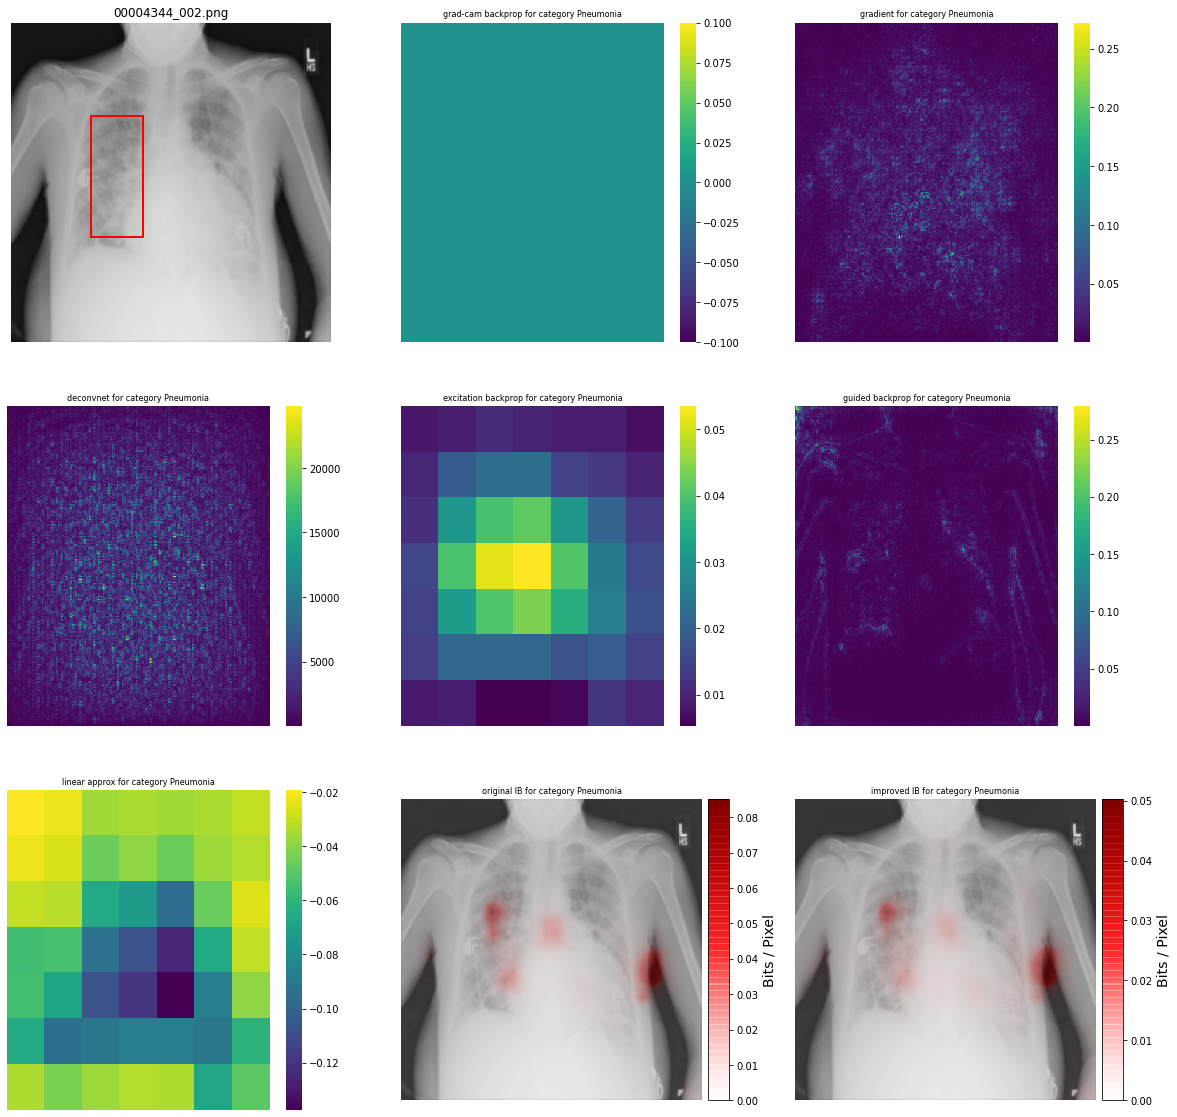

                   Predicted Probability  Ground Truth
Finding                                               
Infiltration                       0.406         False
Cardiomegaly                       0.316         False
Edema                              0.148         False
Consolidation                      0.097         False
Effusion                           0.088         False
Nodule                             0.077         False
Pneumonia                          0.053          True
Atelectasis                        0.016         False
Mass                               0.015         False
Pneumothorax                       0.013         False
Pleural_Thickening                 0.013         False
Fibrosis                           0.012         False
Emphysema                          0.002         False
Hernia                             0.001         False


In [17]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
# axes_a = axes.flatten()[0:6]
axes_b = axes.flatten()[7]
axes_c = axes.flatten()[8]
inputs, labels, filename, bbox, preds = V.plot_map(model, dataloader, LABEL, saliency_layer='features.norm5', axes_a=axes)
target = labels.squeeze()
show_iba(LABEL, inputs.squeeze(), target, filename, bbox, axes_b)
show_iba_new(LABEL, inputs.squeeze(), target, filename, bbox, axes_c)
plt.show()
print(preds)
